Complete the exercises below For **Assignment #5**.

In this exercise, we are building a logistic regression classification model. We'll work with the [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database).  

Load the `tidymodels` library. 

In [1]:
library('tidymodels')

Warning message:
“Your system is mis-configured: ‘/var/db/timezone/localtime’ is not a symlink”
Warning message:
“‘/var/db/timezone/localtime’ is not identical to any known timezone file”
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



The data is located in your homework directory in the `diabetes.csv` file. Read in the data by running the following cell. We are "splitting" the data into training and testing sets. We will evaluate our model's performance with the test set.

In [2]:
diabetes = readr::read_csv('diabetes.csv') |> mutate(Outcome = factor(Outcome))

split = initial_split(diabetes, strata = Outcome)

diabetes_train = training(split)
diabetes_test = testing(split)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Glimpse the `diabetes_train` table.

In [3]:
glimpse(diabetes_train)

Rows: 576
Columns: 9
$ Pregnancies              <dbl> 10, 4, 10, 3, 8, 1, 13, 5, 3, 6, 10, 4, 3, 7,…
$ Glucose                  <dbl> 115, 110, 139, 126, 99, 97, 145, 117, 88, 92,…
$ BloodPressure            <dbl> 0, 92, 80, 88, 84, 66, 82, 92, 58, 92, 78, 60…
$ SkinThickness            <dbl> 0, 0, 0, 41, 0, 15, 19, 0, 11, 0, 31, 33, 25,…
$ Insulin                  <dbl> 0, 0, 0, 235, 0, 140, 110, 0, 54, 0, 0, 192, …
$ BMI                      <dbl> 35.3, 37.6, 27.1, 39.3, 35.4, 23.2, 22.2, 34.…
$ DiabetesPedigreeFunction <dbl> 0.134, 0.191, 1.441, 0.704, 0.388, 0.487, 0.2…
$ Age                      <dbl> 29, 30, 57, 27, 50, 22, 57, 38, 22, 28, 45, 3…
$ Outcome                  <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …


❓ Which variable is suitable as the "outcome" in a logistic regression model?

**Answer:**

The Outcome variable is suitable as the "outcome" in a logistic regression model because it is the only categorical variable (either they have diabetes or they don't).

❓ Navigate to [Kaggle page](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) for this dataset. Find descriptions for the `Glucose` and `BMI` columns. Add these descriptions to the [Markdown table](https://www.markdownguide.org/extended-syntax/#tables) below.

| Column name | Description |
| :---------- | :---------- |
| Glucose     |Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
| BMI         |Body mass index (weight in kg/(height in m)^2)|

Make a bar chart showing the frequency of each "outcome" in the `Outcome` column from your `diabetes_train` data.

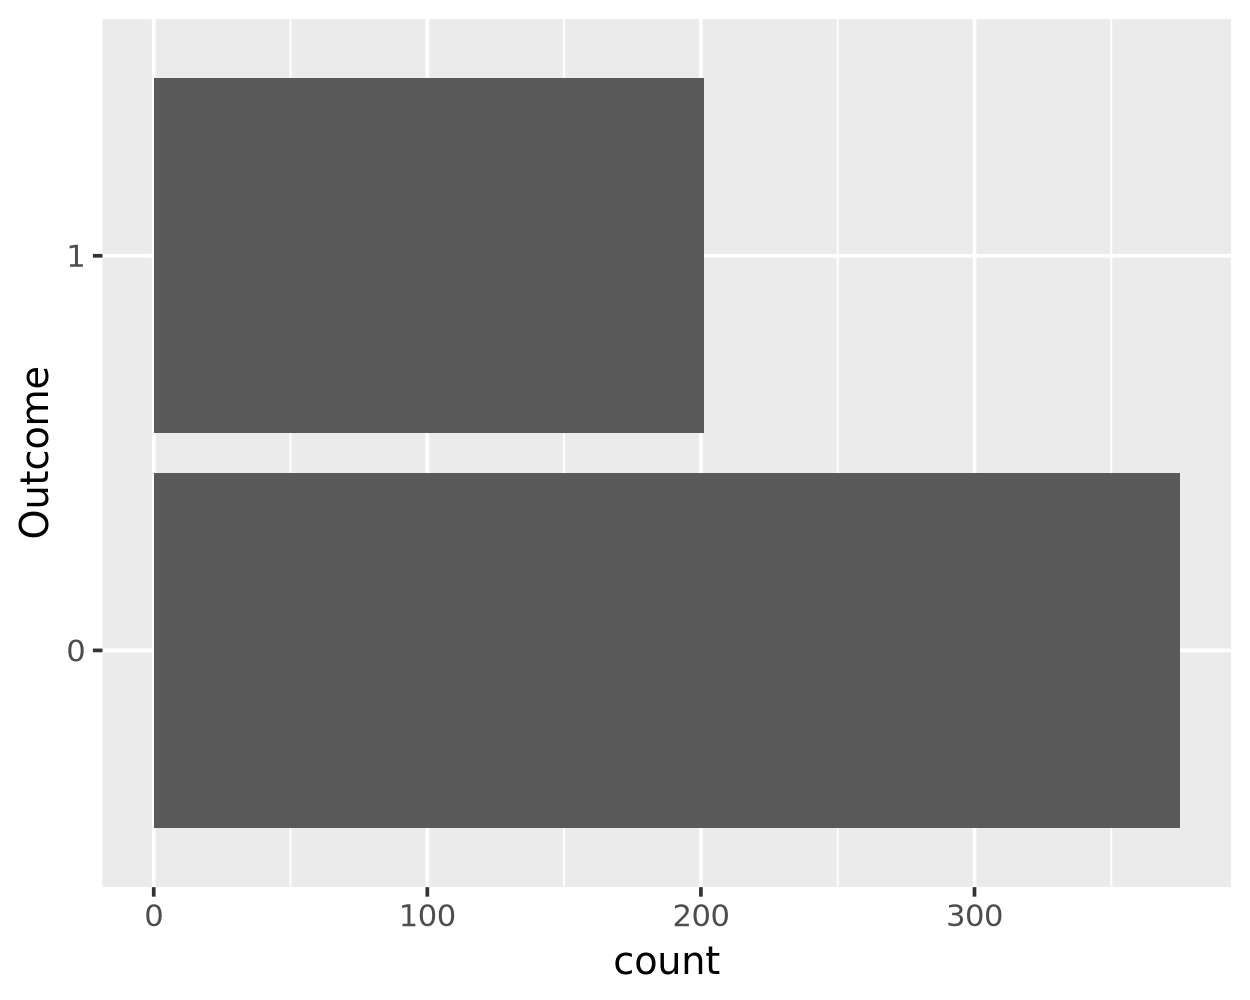

In [11]:
p = ggplot(data=diabetes_train, aes(y=Outcome)) +
  geom_bar()
p

❓ Is the data balanced? I.e. do we have equal counts of each outcome?

**Answer:**

No, there are about twice as many people that do not have diabetes than who do have diabetes.

Run the code below to create a table for plotting the predictors we will use in our model: `Glucose` and `BMI`. 

In [5]:
plot_df = diabetes_train |>
    select(Outcome, Glucose, BMI) |>
    pivot_longer(cols = c(Glucose, BMI))

plot_df |> head()

Outcome,name,value
<fct>,<chr>,<dbl>
0,Glucose,115.0
0,BMI,35.3
0,Glucose,110.0
0,BMI,37.6
0,Glucose,139.0
0,BMI,27.1


Using `plot_df`, make a chart showing the relationship of `Glucose` and `BMI` with `Outcome`. 

- use `geom_jitter` for your "geom"
- `facet_wrap` your chart by the `name` variable. (e.g. `facet_wrap(~name, ncol = 2, scales = 'free_x')`)

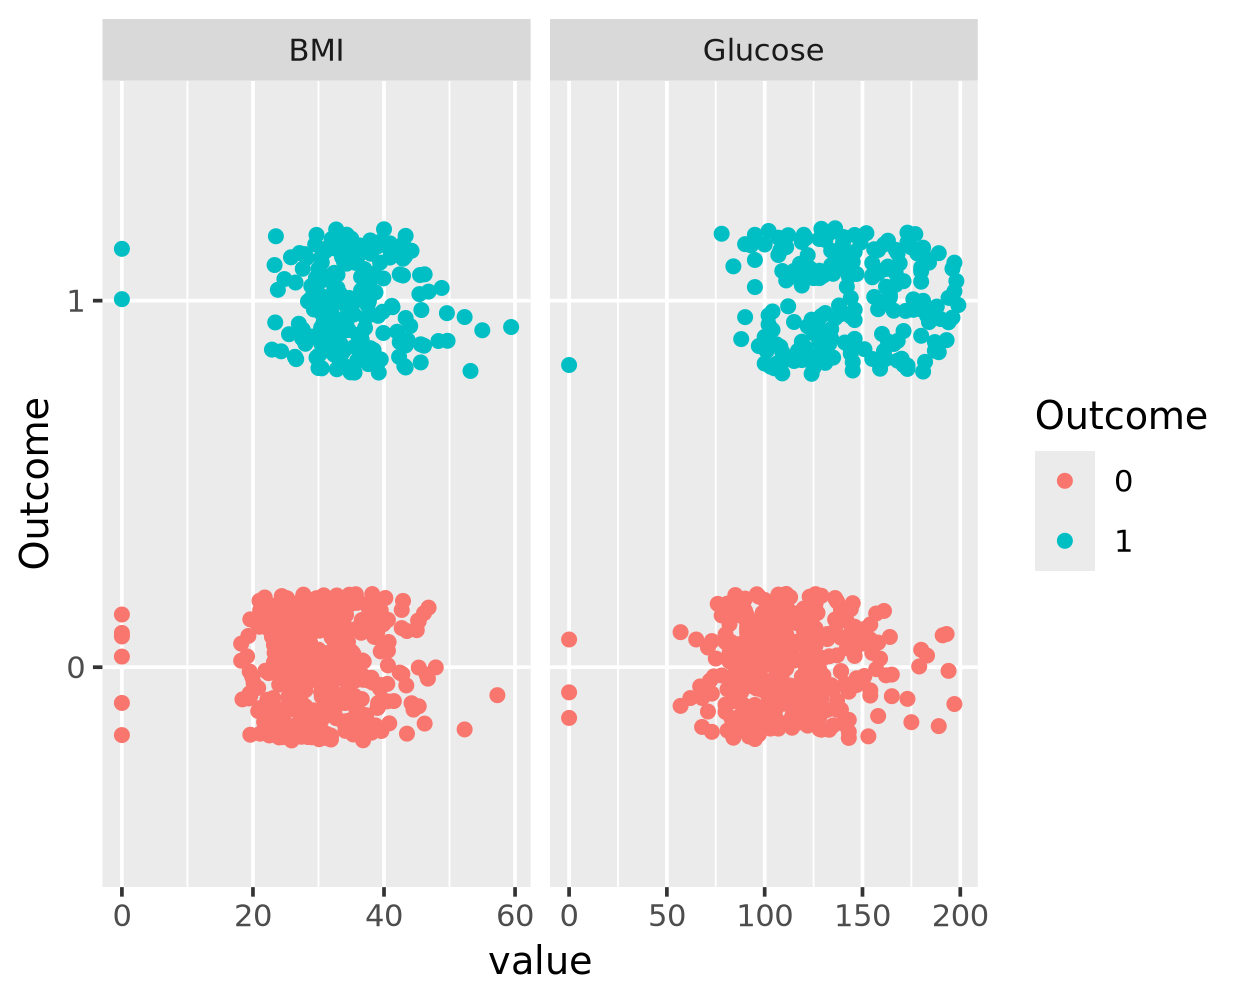

In [15]:
p = ggplot(data = plot_df, aes(x = value, y = Outcome, color = Outcome)) + 
    geom_point(position = position_jitter(width = 0, height = 0.2)) + 
    facet_wrap(~name, ncol = 2, scales = 'free_x')

p

❓ What happens when you remove the `scales = 'free_x'` argument from the `facet_wrap` function?

**Answer:**

It uses the same x range for both the BMI and Glucose charts so the BMI chart ends up getting very squished to the left hand side because the values are smaller on average than that of the Glucose levels.

Using your training data, build logistic regression model of `Outcome` with `BMI` and `Glucose` as predictors. 
- Use "glm" for you engine
- The formula for your fit function will be `Outcome ~ BMI + Glucose`

In [8]:
rec = recipe(Outcome ~ BMI + Glucose, data = diabetes_train) |> 
    step_naomit(everything()) |>   # remove missing values
    prep()                         # run the recipe on the training data provided

mod = logistic_reg() |> set_engine('glm')

mod_fit = mod |> fit(Outcome ~ ., juice(rec))
mod_fit

parsnip model object


Call:  stats::glm(formula = Outcome ~ ., family = stats::binomial, data = data)

Coefficients:
(Intercept)          BMI      Glucose  
   -7.24551      0.07198      0.03405  

Degrees of Freedom: 575 Total (i.e. Null);  573 Residual
Null Deviance:	    745.1 
Residual Deviance: 588.6 	AIC: 594.6

Using `augment` with your fitted model and the `diabetes_test` data as arguments, create a new dataset called `diabetes_test_wPred` that is the `diabetes_test` table including predictions from your model. 

In [9]:
diabetes_test_wPred = augment(mod_fit, diabetes_test)

glimpse(diabetes_test_wPred)

Rows: 192
Columns: 12
$ .pred_class              <fct> 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, …
$ .pred_0                  <dbl> 0.4470230, 0.9195634, 0.8995516, 0.8104283, 0…
$ .pred_1                  <dbl> 0.55297698, 0.08043658, 0.10044838, 0.1895716…
$ Pregnancies              <dbl> 6, 1, 1, 5, 1, 0, 1, 10, 7, 5, 11, 7, 1, 2, 5…
$ Glucose                  <dbl> 148, 85, 89, 116, 189, 118, 103, 125, 147, 10…
$ BloodPressure            <dbl> 72, 66, 66, 74, 60, 84, 30, 70, 76, 75, 76, 0…
$ SkinThickness            <dbl> 35, 29, 23, 0, 23, 47, 38, 26, 0, 26, 0, 0, 1…
$ Insulin                  <dbl> 0, 0, 94, 0, 846, 230, 83, 115, 0, 0, 0, 0, 3…
$ BMI                      <dbl> 33.6, 26.6, 28.1, 25.6, 30.1, 45.8, 43.3, 31.…
$ DiabetesPedigreeFunction <dbl> 0.627, 0.351, 0.167, 0.201, 0.398, 0.551, 0.1…
$ Age                      <dbl> 50, 31, 21, 30, 59, 31, 33, 41, 43, 60, 35, 2…
$ Outcome                  <fct> 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, …


Run the code below to generate a confusion matrix for your model predictions. 

(❗️Hint: See Table 4.4 from [*Introduction to Statistical Learning (Version 2)*](https://www.statlearning.com/) for an example confusion matrix.)

In [10]:
diabetes_test_wPred = augment(mod_fit, new_data = diabetes_test)

diabetes_test_wPred |> conf_mat(Outcome, .pred_class)

          Truth
Prediction   0   1
         0 115  29
         1  10  38

❓ Based on the confusion matrix above, 
- How many individuals had diabetes in your test data?
- Of those that actually had diabetes, how many were predicted to have diabetes by your model?
- How many individuals predicted to have diabetes did not have diabetes?

**Answer:**

- 67 individuals had diabetes in the test data
- 38 were predicted to have diabetes who actually had diabetes
- 10 individuals were predicted to have diabetes but did not have diabetes